In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, SpatialDropout1D, GlobalAveragePooling1D, Layer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


In [2]:

# Load your dataset (assuming 'clean_text' and 'generated' columns)
#df = pd.read_csv('LLM_Datasets/train_essays_7_prompts.csv')
df = pd.read_csv('Training_Essay_Data.csv', encoding='latin1')


In [3]:
# Data Preprocessing and Cleaning
def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    return text



In [4]:

df['clean_text'] = df['text'].apply(clean_text)


In [5]:
# Tokenization, stopwords removal, and lemmatization
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()


In [6]:

def preprocess_text(text):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return tokens



In [7]:
df['tokens'] = df['clean_text'].apply(preprocess_text)




In [8]:
# Convert text data into numerical representations: Padding
max_seq_length = 100  # Choose an appropriate sequence length
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(df['clean_text'])
X_seq = tokenizer.texts_to_sequences(df['clean_text'])
X_pad = pad_sequences(X_seq, maxlen=max_seq_length)


In [9]:
# Define features (X) and target variable (y)
X = X_pad
y = df['generated']


In [10]:

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)



In [11]:
# Define LSTM Model with Attention Mechanism
class Attention(Layer):
    def __init__(self, return_sequences=True):
        self.return_sequences = return_sequences
        super(Attention, self).__init__()

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1), initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1), initializer="zeros")
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = tf.keras.activations.tanh(tf.keras.backend.dot(x, self.W) + self.b)
        a = tf.keras.activations.softmax(e, axis=1)
        output = x * a
        if self.return_sequences:
            return output
        return tf.keras.backend.sum(output, axis=1)



In [12]:
from tensorflow.keras.layers import Layer, Input
from tensorflow.keras.models import Model

class Attention(Layer):
    def __init__(self, return_sequences=True, **kwargs):
        super(Attention, self).__init__(**kwargs)
        self.return_sequences = return_sequences

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1), initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1), initializer="zeros")
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = tf.keras.activations.tanh(tf.keras.backend.dot(x, self.W) + self.b)
        a = tf.keras.activations.softmax(e, axis=1)
        output = x * a
        if self.return_sequences:
            return output
        return tf.keras.backend.sum(output, axis=1)




In [13]:
def create_lstm_model(input_dim, output_dim, max_sequence_length):
    inputs = Input(shape=(max_sequence_length,))
    x = Embedding(input_dim, output_dim, input_length=max_sequence_length)(inputs)
    x = SpatialDropout1D(0.2)(x)
    x = Bidirectional(LSTM(64, return_sequences=True))(x)
    x = Attention(return_sequences=True)(x)
    x = GlobalAveragePooling1D()(x)
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [14]:
input_dim = len(tokenizer.word_index) + 1
output_dim = 100
max_sequence_length = X_pad.shape[1]


In [15]:

# Create LSTM model with attention
lstm_model = create_lstm_model(input_dim, output_dim, max_sequence_length)



C:\Users\Ahmedma\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [16]:
# Train the model
history = lstm_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, batch_size=32)


Epoch 1/5
603/603 ━━━━━━━━━━━━━━━━━━━━ 66s 102ms/step - accuracy: 0.6713 - loss: 0.6314 - val_accuracy: 0.8836 - val_loss: 0.4319
Epoch 2/5
603/603 ━━━━━━━━━━━━━━━━━━━━ 62s 103ms/step - accuracy: 0.8787 - loss: 0.4112 - val_accuracy: 0.9584 - val_loss: 0.2809
Epoch 3/5
603/603 ━━━━━━━━━━━━━━━━━━━━ 62s 103ms/step - accuracy: 0.9640 - loss: 0.2593 - val_accuracy: 0.9752 - val_loss: 0.1910
Epoch 4/5
603/603 ━━━━━━━━━━━━━━━━━━━━ 60s 100ms/step - accuracy: 0.9778 - loss: 0.1702 - val_accuracy: 0.9469 - val_loss: 0.1698
Epoch 5/5
603/603 ━━━━━━━━━━━━━━━━━━━━ 62s 104ms/step - accuracy: 0.9669 - loss: 0.1364 - val_accuracy: 0.9603 - val_loss: 0.1346


In [17]:

# Evaluate the model
_, accuracy = lstm_model.evaluate(X_val, y_val)
print(f'Validation Accuracy: {accuracy:.2f}')



259/259 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9602 - loss: 0.1348
Validation Accuracy: 0.96


In [18]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences

def visualize_attention_weights(model, text, tokenizer, max_seq_length):
    # Tokenize and pad the sequence
    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=max_seq_length)

    # Define a new model to output attention weights
    attention_layer = None
    for layer in model.layers:
        if isinstance(layer, Attention):
            attention_layer = layer
            break

    if attention_layer is None:
        raise ValueError("Attention layer not found in the model.")

    attention_model = tf.keras.Model(inputs=model.input, outputs=attention_layer.output)
    attention_weights = attention_model.predict(padded)[0]  # Assuming batch size 1

    # Plot heatmap of attention weights
    plt.figure(figsize=(10, 6))
    plt.imshow(attention_weights, cmap='viridis', interpolation='nearest')
    plt.title('Attention Weights')
    plt.xlabel('Tokens')
    plt.ylabel('Time Steps')
    plt.colorbar()
    plt.xticks(range(len(seq[0])), seq[0], rotation=45)
    plt.tight_layout()
    plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


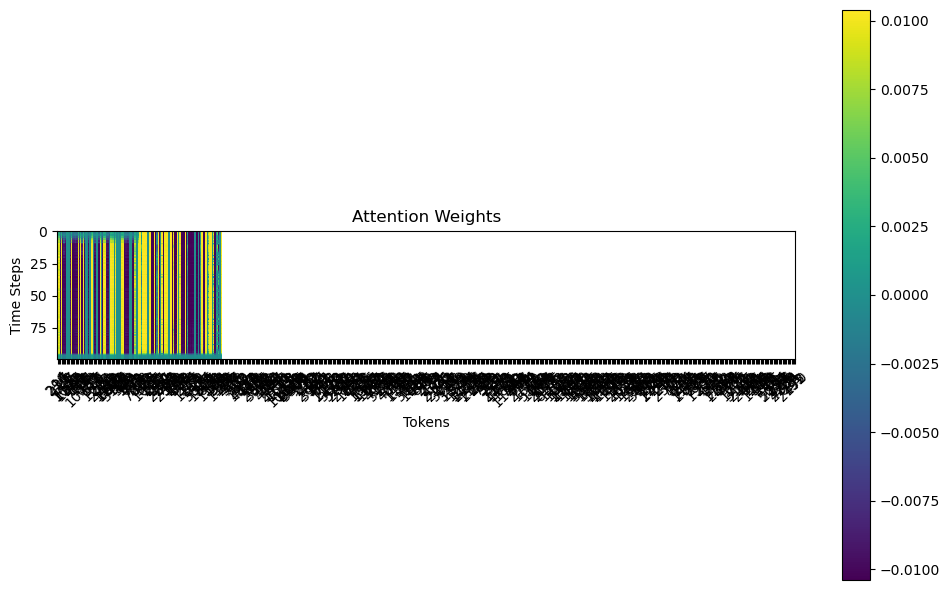

In [19]:
# Example usage: Visualize attention for a specific text
text_to_visualize = df['clean_text'].iloc[0]
visualize_attention_weights(lstm_model, text_to_visualize, tokenizer, max_sequence_length)
